In [1]:
import pandas as pd

In [2]:
# !./pasta analyse rep

In [3]:
# !./pasta rate

In [4]:
# !./pasta analyse upstream

In [5]:
# !./pasta rate

In [6]:
# !./pasta offlist

In [7]:
by_author = pd.read_csv('by_author')
by_author.columns = ['Author', 'commit']
by_author['commit'] = by_author['commit'].map(lambda x: x.split(','))
by_author.set_index('Author', inplace=True)
by_author = pd.melt(by_author['commit'].apply(pd.Series).reset_index(), 
            id_vars=['Author'],
            value_name='commit').sort_index()
by_author.drop('variable', axis=1, inplace=True)

In [8]:
offlist = by_author[['commit']].dropna()

In [9]:
# Commit csv file generated from gitdm. Refer to:
# https://github.com/basakerdamar/gitdm/blob/commit-miner/get_commits.py
df_repo = pd.read_csv('commitsv5.0..v5.8.csv', 
                      usecols=['commit','date','author.name','author.email', 'files'])\
                        .fillna('')
df_repo['date'] = pd.to_datetime(df_repo['date']).dt.to_period('W').map(lambda x: x.to_timestamp())

In [10]:
from pypasta import Config

config = Config('linux')

repo = config.repo

#repo.linux_mainline_tags
releases = ['v5.0-rc1', 'v5.0-rc2', 'v5.0-rc3', 'v5.0-rc4', 'v5.0-rc5', 'v5.0-rc6', 'v5.0-rc7', 'v5.0-rc8', 'v5.0', 
          'v5.1-rc1', 'v5.1-rc2', 'v5.1-rc3', 'v5.1-rc4', 'v5.1-rc5', 'v5.1-rc6', 'v5.1-rc7', 'v5.1',
          'v5.2-rc1', 'v5.2-rc2', 'v5.2-rc3', 'v5.2-rc4', 'v5.2-rc5', 'v5.2-rc6', 'v5.2-rc7', 'v5.2',
          'v5.3-rc1', 'v5.3-rc2', 'v5.3-rc3', 'v5.3-rc4', 'v5.3-rc5', 'v5.3-rc6', 'v5.3-rc7', 'v5.3-rc8', 'v5.3',
         'v5.4-rc1', 'v5.4-rc2', 'v5.4-rc3', 'v5.4-rc4', 'v5.4-rc5', 'v5.4-rc6', 'v5.4-rc7', 'v5.4-rc8',  'v5.4',
         'v5.5-rc1', 'v5.5-rc2', 'v5.5-rc3', 'v5.5-rc4', 'v5.5-rc5', 'v5.5-rc6', 'v5.5-rc7',  'v5.5',
          'v5.6-rc1', 'v5.6-rc2', 'v5.6-rc3', 'v5.6-rc4', 'v5.6-rc5', 'v5.6-rc6', 'v5.6-rc7', 'v5.6',
         'v5.7-rc1', 'v5.7-rc2', 'v5.7-rc3', 'v5.7-rc4', 'v5.7-rc5', 'v5.7-rc6', 'v5.7-rc7','v5.7',
 '']

commits_by_release = pd.DataFrame(columns=['commit', 'range'])

for index, release in enumerate(releases):
    if index == len(releases) - 1:
        break
    window = release+'..'+releases[index+1]
    commithash_range = pd.DataFrame([[commit_hash, window] for commit_hash in repo.get_commithash_range(window)],
                                   columns=['commit', 'range'])
    commits_by_release = pd.concat([commits_by_release, commithash_range])

commits_by_release.head()

,commit,range
0,1c7fc5cbc33980acd13d668f1c8f0313d6ae9fd8,v5.0-rc1..v5.0-rc2
1,b7285b425318331c2de4af2a784a18e6dccef484,v5.0-rc1..v5.0-rc2
2,e1706720408e72fb883f6b151c2b3b23d8e7e5b2,v5.0-rc1..v5.0-rc2
3,bde0b5c109e8b22b57745e3b9914f9e87ad857ea,v5.0-rc1..v5.0-rc2
4,2f558bc3f33ca344489cec2218545741028b6a70,v5.0-rc1..v5.0-rc2


In [11]:
df_repo = pd.merge(df_repo, commits_by_release, on='commit', how='left')

In [12]:
del commits_by_release

In [13]:
df_repo['version'] = df_repo['range'].str.extract('[.]{2}(v[0-9]+.[0-9]+)')
df_repo['rc'] = df_repo['range'].str.extract('rc([0-9]+)$').fillna('-')
df_repo['rc'] = pd.Categorical(df_repo['rc'], 
                               categories = ['1','2','3','4','5','6', '7', '8', '-'],
                                ordered=True)
df_repo.head()

,commit,date,author.name,author.email,files,range,version,rc
0,bcf876870b95592b52519ed4aafcf9d95999bc9c,2020-07-27,Linus Torvalds,torvalds@linux-foundation.org,,v5.7..,NaN,-
1,5a30a78924ecd97b0335d2e1d3e01a5023c1a3d8,2020-07-27,Linus Torvalds,torvalds@linux-foundation.org,,NaN,NaN,-
2,142c3326b055a278c303bfef8dc6a105fff18ca6,2020-07-27,Linus Torvalds,torvalds@linux-foundation.org,,NaN,NaN,-
3,628e04dfeb4f66635c0d22cf1ad0cf427406e129,2020-07-27,Linus Torvalds,torvalds@linux-foundation.org,,NaN,NaN,-
4,28ab576ba8de934ee3145b6d75119f016de567cb,2020-07-27,Masahiro Yamada,masahiroy@kernel.org,scripts/Makefile.modpost,v5.7..,NaN,-


In [14]:
offlist = pd.merge(offlist, df_repo, how='left', right_on='commit', left_on='commit')
offlist.head()

,commit,date,author.name,author.email,files,range,version,rc
0,156e42996bd84eccb6acf319f19ce0cb140d00e3,2019-06-10,Mike Salvatore,mike.salvatore@canonical.com,security/apparmor/policy_unpack.c,v5.2-rc5..v5.2-rc6,v5.2,6
1,4c6d80e1144bdf48cae6b602ae30d41f3e5c76a9,2019-07-01,Norbert Manthey,nmanthey@amazon.de,fs/pstore/inode.c,v5.2..v5.3-rc1,v5.3,1
2,d4a8061a7c5f7c27a2dc002ee4cb89b3e6637e44,2019-08-26,Heyi Guo,guoheyi@huawei.com,virt/kvm/arm/vgic/vgic.c,v5.3-rc6..v5.3-rc7,v5.3,7
3,e2995b95a914bbc6b5352be27d5d5f33ec802d2c,2019-10-21,Justin Song,flyingecar@gmail.com,sound/usb/quirks.c,v5.4-rc5..v5.4-rc6,v5.4,6
4,a2f10d4a3069fee666dab20fab5458757ba1f22d,2019-10-21,Christian Gmeiner,christian.gmeiner@gmail.com,drivers/gpu/drm/etnaviv/etnaviv_iommu_v2.c,v5.4-rc5..v5.4-rc6,v5.4,6


In [15]:
len(offlist)

10226

### Authors

The authors that made the largest amount of off-list commits in the selected release window

In [16]:
offlist.groupby('author.name')\
        .size()\
        .sort_values(ascending=False)[:20]

author.name
Ben Skeggs               207
Andy Shevchenko          173
Mauro Carvalho Chehab    160
Linus Torvalds           142
Al Viro                  138
Bart Van Assche          123
Vasily Gorbik             97
Thomas Gleixner           97
Rafael J. Wysocki         95
Gustavo A. R. Silva       92
Sean Christopherson       92
Miklos Szeredi            90
Jens Axboe                90
Tony Lindgren             90
James Smart               87
Leon Romanovsky           79
Linus Walleij             79
Greg Kroah-Hartman        76
Hans de Goede             75
Thierry Reding            64
dtype: int64

In [17]:
index = ['commit','date','author.name','author.email']
offlist_denorm = offlist.set_index(index)

In [18]:
offlist_denorm['files'] = offlist_denorm['files'].str.split(',')

In [19]:
offlist_denorm = pd.melt(offlist_denorm['files'].apply(pd.Series).reset_index(), 
            id_vars=index,
            value_name='files').sort_index()
offlist_denorm.drop('variable', axis=1, inplace=True)

### Changed Files

Files that were the most frequently changed by the off-list commits. Empty file name means no kernel file was changed, e.g. Linus Torvalds changing the version name on git for a new release.

In [20]:
offlist_denorm.groupby('files')\
        .size()\
        .sort_values(ascending=False)[:20]

files
MAINTAINERS                                          123
fs/io_uring.c                                         80
                                                      70
include/rdma/ib_verbs.h                               62
drivers/infiniband/core/device.c                      59
drivers/gpu/drm/i915/i915_drv.h                       58
fs/fuse/file.c                                        47
drivers/infiniband/hw/hfi1/tid_rdma.c                 44
arch/x86/kvm/vmx/vmx.c                                43
drivers/scsi/qla2xxx/qla_os.c                         41
drivers/s390/cio/qdio_main.c                          41
drivers/scsi/megaraid/megaraid_sas_base.c             40
drivers/scsi/lpfc/lpfc_init.c                         38
drivers/scsi/qla2xxx/qla_init.c                       37
drivers/infiniband/hw/hns/hns_roce_hw_v2.c            37
drivers/gpu/drm/nouveau/nvkm/engine/device/base.c     35
drivers/infiniband/hw/mlx5/main.c                     35
fs/fuse/dev.c            

#### Maintainer status of the authors

In [21]:
from pypasta.LinuxMaintainers import LinuxMaintainers

all_maintainers = LinuxMaintainers(repo, revision='v5.8')

def check_if_maintainer(line):
    try:
        maintainers = []
        filenames = line['files'].split(',')
        for filename in filenames:
            sections = all_maintainers.get_sections_by_file(filename)
            sections -= {'THE REST'}
            for section in sections:
                _, mtrs, _ = all_maintainers.get_maintainers(section)
                maintainers += mtrs
        return line['author.name'].lower() in [x[0].lower() for x in maintainers]
    except:
        raise

offlist['author_is_maintainer'] = offlist.apply(check_if_maintainer, axis=1)

How many of the off-list commits were made by maintainers:

In [22]:
offlist['author_is_maintainer'].value_counts()

False    7123
True     3103
Name: author_is_maintainer, dtype: int64

### Off-list vs. total number of commits by time

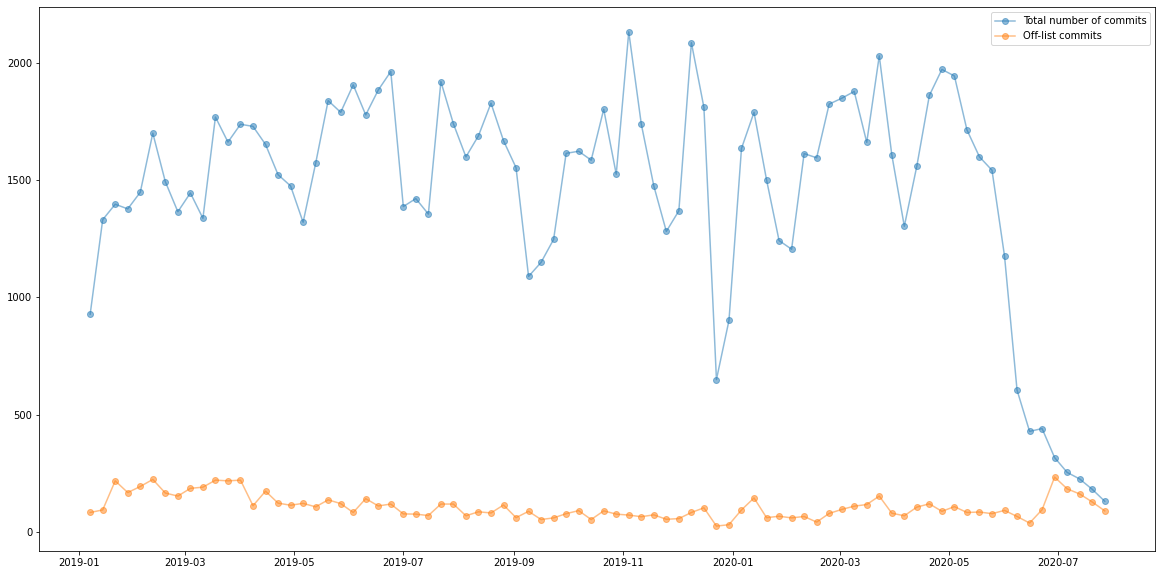

In [23]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots(figsize=(20, 10))


# Plot total number of commits
mask = (df_repo['date'] > '2019-01-01') & (df_repo['date'] <= '2020-08-02')
ax.plot(df_repo.loc[mask].groupby('date').count().reset_index()['date'],
        df_repo.loc[mask].groupby('date').count().reset_index()['commit'],
        marker='o', alpha=0.5)

# Plot the number of off-list commits
mask = (offlist['date'] > '2019-01-01') & (offlist['date'] <= '2020-08-02')
ax.plot(offlist.loc[mask].groupby('date').count().reset_index()['date'],
        offlist.loc[mask].groupby('date').count().reset_index()['commit'],
        marker='o', alpha=0.5)

ax.legend(['Total number of commits', 'Off-list commits'])

ax.figure.savefig('total_vs_off-list_by_time.pdf', bbox_inches = "tight")

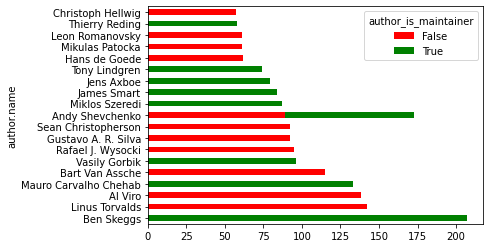

In [24]:
ax = offlist.groupby('author.name')['author_is_maintainer']\
        .value_counts()\
        .sort_values(ascending=False)[:20]\
        .unstack()\
        .plot.barh(stacked=True, color=['r','g'])

ax.figure.savefig('top_off-list_authors.pdf', bbox_inches = "tight")

In [25]:
repo_authors = df_repo.groupby('author.name')\
                        .nunique()['commit']\
                        .reset_index()
offlist_authors = offlist.groupby(['author.name'])\
                            .nunique()['commit']\
                            .reset_index()
authors = pd.merge(repo_authors, offlist_authors, on='author.name', how='left').fillna(0)
authors['offlist (%)'] = authors.apply(lambda x: 100*x['commit_y']/(x['commit_x']), axis=1)

In [26]:
authors.sort_values('commit_y', ascending=False)[:20]

,author.name,commit_x,commit_y,offlist (%)
551,Ben Skeggs,211,207.0,98.104265
354,Andy Shevchenko,821,173.0,21.071864
3037,Mauro Carvalho Chehab,1092,160.0,14.652015
2658,Linus Torvalds,3530,142.0,4.022663
89,Al Viro,481,138.0,28.690229
524,Bart Van Assche,382,123.0,32.198953
4510,Thomas Gleixner,1092,97.0,8.882784
4714,Vasily Gorbik,116,97.0,83.620690
3750,Rafael J. Wysocki,423,95.0,22.458629
1613,Gustavo A. R. Silva,881,92.0,10.442679


In [27]:
# authors.sort_values('offlist (%)', ascending=False)[:20].plot.barh(x='author.name', y='offlist (%)')

In [28]:
# authors.sort_values('commit_y', ascending=False)[:20].plot.barh(x='author.name', y='offlist (%)')

Off-list percentage for each author is calculated by the number of off-list commits made by author divided by the total number of commits.

Below are the off-list percentage of commits compared to the total number of commits for the selected commit window. Each dot on the plot represents an author.

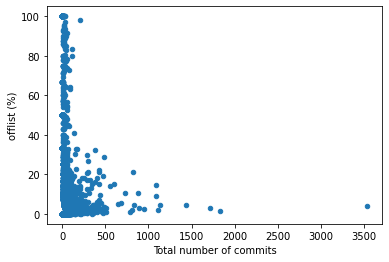

In [29]:
ax = authors.plot.scatter(x='commit_x', y='offlist (%)')
ax.set_xlabel('Total number of commits')
ax.figure.savefig('total_vs_off-list_percentage.pdf', bbox_inches = "tight")

Below are the absolute number of off-list commits compared to the total number of commits. Again, each dot on the plot represents an author.

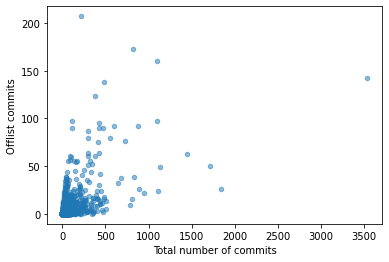

In [30]:
ax = authors.plot.scatter(x='commit_x', y='commit_y', alpha=0.5)

ax.set_xlabel('Total number of commits')
ax.set_ylabel('Offlist commits')

ax.figure.savefig('total_vs_off-list.pdf', bbox_inches = "tight")

Below, I inspect whether there is a correlation between total number of commits anf the number of off-list commits per author.

In [31]:
authors[['commit_x', 'commit_y']].corr()

,commit_x,commit_y
commit_x,1.000000,0.612957
commit_y,0.612957,1.000000


<AxesSubplot:ylabel='Frequency'>

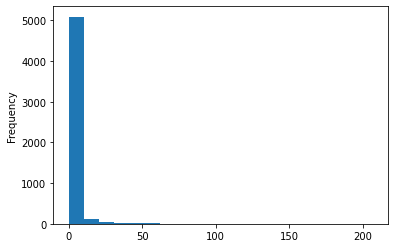

In [32]:
authors['commit_y'].plot.hist(bins=20)

### Off-list commit percentage per release candidate

In [33]:
# release_dates = {
#                     '5':'2019-03-03',
#                     '5.1':'2019-05-05',
#                     '5.2':'2019-07-07',
#                     '5.3':'2019-09-15',
#                     '5.4':'2019-11-24',
#                     '5.5':'2019-01-26',
#                     '5.6':'2019-03-29',
#                     '5.7':'2019-05-31',
#                     '5.8':'2019-08-02'
#                     }

In [34]:
filter_version= [
#     'v5.0..v5.1-rc1',
#  'v5.1-rc1..v5.1-rc2',
#  'v5.1-rc2..v5.1-rc3',
#  'v5.1-rc3..v5.1-rc4',
#  'v5.1-rc4..v5.1-rc5',
#  'v5.1-rc5..v5.1-rc6',
#  'v5.1-rc6..v5.1-rc7',
#  'v5.1-rc7..v5.1',
#  'v5.1..v5.2-rc1',
#  'v5.2-rc1..v5.2-rc2',
#  'v5.2-rc2..v5.2-rc3',
#  'v5.2-rc3..v5.2-rc4',
#  'v5.2-rc4..v5.2-rc5',
#  'v5.2-rc5..v5.2-rc6',
#  'v5.2-rc6..v5.2-rc7',
#  'v5.2-rc7..v5.2',
 'v5.2..v5.3-rc1',
 'v5.3-rc1..v5.3-rc2',
 'v5.3-rc2..v5.3-rc3',
 'v5.3-rc3..v5.3-rc4',
 'v5.3-rc4..v5.3-rc5',
 'v5.3-rc5..v5.3-rc6',
 'v5.3-rc6..v5.3-rc7',
 'v5.3-rc7..v5.3-rc8',
 'v5.3-rc8..v5.3',
 'v5.3..v5.4-rc1',
 'v5.4-rc1..v5.4-rc2',
 'v5.4-rc2..v5.4-rc3',
 'v5.4-rc3..v5.4-rc4',
 'v5.4-rc4..v5.4-rc5',
 'v5.4-rc5..v5.4-rc6',
 'v5.4-rc6..v5.4-rc7',
 'v5.4-rc7..v5.4-rc8',
 'v5.4-rc8..v5.4',
 'v5.4..v5.5-rc1',
 'v5.5-rc1..v5.5-rc2',
 'v5.5-rc2..v5.5-rc3',
 'v5.5-rc3..v5.5-rc4',
 'v5.5-rc4..v5.5-rc5',
 'v5.5-rc5..v5.5-rc6',
 'v5.5-rc6..v5.5-rc7',
 'v5.5-rc7..v5.5',
 'v5.5..v5.6-rc1',
 'v5.6-rc1..v5.6-rc2',
 'v5.6-rc2..v5.6-rc3',
 'v5.6-rc3..v5.6-rc4',
 'v5.6-rc4..v5.6-rc5',
 'v5.6-rc5..v5.6-rc6',
 'v5.6-rc6..v5.6-rc7',
 'v5.6-rc7..v5.6',
 'v5.6..v5.7-rc1',
 'v5.7-rc1..v5.7-rc2',
 'v5.7-rc2..v5.7-rc3',
 'v5.7-rc3..v5.7-rc4',
 'v5.7-rc4..v5.7-rc5',
 'v5.7-rc5..v5.7-rc6',
 'v5.7-rc6..v5.7-rc7',
 'v5.7-rc7..v5.7',
 'v5.7..']
offlist = offlist[offlist['range'].map(lambda x: x in filter_version)]

/Users/basakerdamar/miniconda3/envs/pasta/lib/python3.8/site-packages/pandas/plotting/_matplotlib/core.py:1192: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(xticklabels)


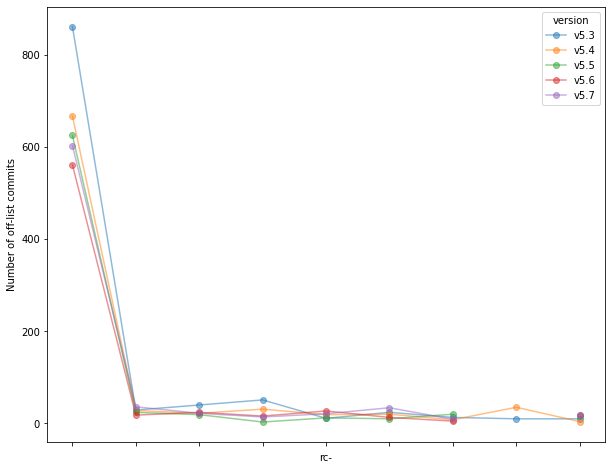

In [35]:
ax = offlist.groupby('rc')['version']\
        .value_counts()\
        .unstack()\
        .plot.line(alpha = 0.5, marker = 'o', figsize=(10, 8))
ax.set_ylabel('Number of off-list commits')
ax.set_xlabel('rc-')
ax.figure.savefig('release_candidate_offlist.pdf')

In [36]:
offlist_counts = offlist.groupby(['version', 'rc']).size().reset_index()
df_repo_counts = df_repo.groupby(['version', 'rc']).size().reset_index()

offlist_ratio = pd.merge(offlist_counts, df_repo_counts, how='left', on = ['version', 'rc'])
offlist_ratio.columns = ['version', 'rc', 'offlist', 'total']
def try_divide(line):
    try:
        return 100 * line['offlist']/line['total']
    except ZeroDivisionError:
        return None
offlist_ratio['ratio'] = offlist_ratio.apply(try_divide, axis=1)

offlist_ratio.head()

,version,rc,offlist,total,ratio
0,v5.3,1,861,12608,6.828997
1,v5.3,2,29,344,8.430233
2,v5.3,3,40,277,14.440433
3,v5.3,4,51,473,10.782241
4,v5.3,5,11,157,7.006369


/Users/basakerdamar/miniconda3/envs/pasta/lib/python3.8/site-packages/pandas/plotting/_matplotlib/core.py:1192: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(xticklabels)


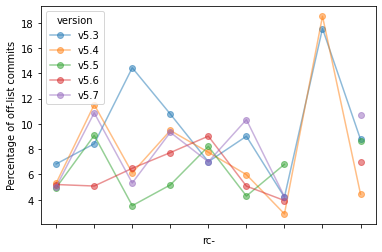

In [37]:
ax = offlist_ratio.pivot( columns='version', index='rc', values = 'ratio')\
        .plot.line(alpha = 0.5, marker = 'o')

ax.set_xlabel('rc-')
ax.set_ylabel('Percentage of off-list commits')
ax.figure.savefig('release_candidate_offlist.pdf', bbox_inches = "tight")

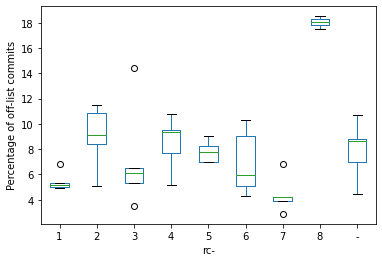

In [38]:
ax = offlist_ratio.pivot(index='version', columns='rc', values = 'ratio')\
                .plot.box()

ax.set_xlabel('rc-')
ax.set_ylabel('Percentage of off-list commits')
ax.figure.savefig('release_candidate_offlist_boxplot.pdf', bbox_inches = "tight")

In [39]:
offlist_ratio['not_offlist'] = offlist_ratio.apply(lambda x: x['total'] - x['offlist'], axis=1)
offlist_ratio.head()

,version,rc,offlist,total,ratio,not_offlist
0,v5.3,1,861,12608,6.828997,11747
1,v5.3,2,29,344,8.430233,315
2,v5.3,3,40,277,14.440433,237
3,v5.3,4,51,473,10.782241,422
4,v5.3,5,11,157,7.006369,146


In [40]:
rc_means = offlist_ratio.groupby('rc').mean().reset_index()[['rc', 'offlist', 'not_offlist']]
rc_means

,rc,offlist,not_offlist
0,1,663.4,11451.0
1,2,27.0,280.2
2,3,25.4,366.0
3,4,23.0,220.0
4,5,18.0,211.4
5,6,20.2,263.4
6,7,11.0,233.0
7,8,9.0,40.2
8,-,13.4,152.4


In [41]:
rc_std = offlist_ratio.groupby('rc').std().reset_index()[['rc', 'offlist', 'not_offlist']]
rc_std

,rc,offlist,not_offlist
0,1,116.905090,725.914596
1,2,6.633250,51.016664
2,3,8.354639,102.366987
3,4,18.560711,142.917809
4,5,6.633250,68.416372
5,6,9.497368,38.939697
6,7,5.787918,71.133677
7,8,15.165751,66.792215
8,-,6.308724,65.485113


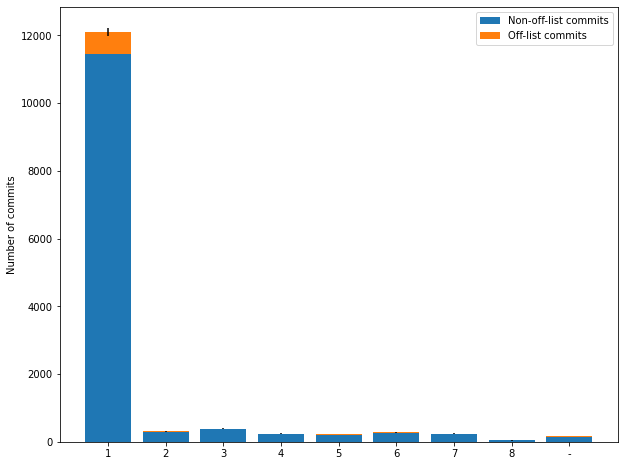

In [42]:
labels =  rc_means['rc'].map(str)
offlist_means = rc_means['offlist']
other_means = rc_means['not_offlist']
offlist_std = rc_std['offlist']
other_std = rc_std['not_offlist']

fig, ax = plt.subplots(figsize=(10, 8))

ax.bar(labels, other_means, 
       label='Non-off-list commits')

ax.bar(labels, offlist_means, yerr=offlist_std, 
       bottom=other_means,
       label='Off-list commits')

ax.set_ylabel('Number of commits')
ax.legend(loc = 'upper right')
ax.figure.savefig('release_candidate_offlist_stacked.pdf', bbox_inches = "tight")
plt.show()